## Regression

In this notebook, I will bring together various techniques for feature engineering to tackle a regression problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for regression.

I will:
- build a lasso
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

===================================================================================================

## In this demo:

We will use the House Prices dataset.

In [2]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from feature_engine import imputation as mdi
from feature_engine import encoding as ce
from feature_engine import discretisation as dsc

In [3]:
# import dataset

data = pd.read_csv('house_price.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# data shape
data.shape

(1460, 81)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Types of variables

Let's go ahead and find out what types of variables there are in this dataset

In [7]:
print(data.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


There are a mixture of categorical and numerical variables.

In [9]:
# there is an id column which we cannot use for prediction

print('Number of Id values: {}'.format(data['Id'].nunique()))
print('Length of the data : {}'.format(len(data)))

Number of Id values: 1460
Length of the data : 1460


Id is a unique identifier for each of the houses. Thus this is not a variable that we can use.

#### Find categorical variables

In [13]:
# categorical variables

categorical = [var for var in data.columns if data[var].dtype == 'O']
print(categorical)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [14]:
print(len(categorical))

43


- There are 43 categorical variables.

In [15]:
data[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Find temporal variables

There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables:


In [16]:
# get numerical variables first
numerical = [var for var in data.columns if data[var].dtype != 'O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]
year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [17]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


We can see that these variables correspond to the years in which the houses were built or remodeled or a garage was built, or the house was indeed sold. It would be better if we capture the time elapsed between the time the house was built and the time the house was sold for example. We are going to do that in the feature engineering section later in the notebook. 

We have another temporal variable: MoSold, which indicates the month in which the house was sold. Let's inspect if the house price varies with the time of the year in which it is sold:

In [18]:
data['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

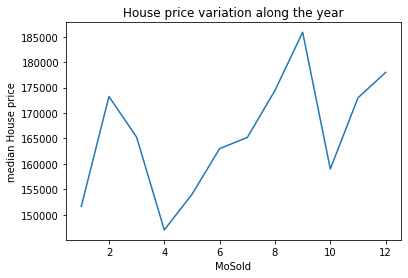

In [24]:
data.groupby('MoSold')['SalePrice'].median().plot()
plt.title('House price variation along the year')
plt.ylabel('median House price')
plt.show();

The price seems to vary depending on the month in which the house is sold.

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [27]:
discrete = [var for var in numerical if len(data[var].value_counts()) < 20 and var not in year_vars]

for var in discrete:
    print(var, data[var].unique())

print()
print('number of discrete variables : {}'.format(len(discrete)))

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
OverallCond [5 8 6 7 4 2 3 9 1]
BsmtFullBath [1 0 2 3]
BsmtHalfBath [0 1 2]
FullBath [2 1 3 0]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [1 2 3 0]
TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces [0 1 2 3]
GarageCars [2 3 1 0 4]
PoolArea [  0 512 648 576 555 480 519 738]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]

number of discrete variables : 14


### continuous variables

In [30]:
numerical = [var for var in numerical if var not in discrete and var not in year_vars and var not in ['Id', 'SalePrice']]
print('number of numerical variables : {}'.format(len(numerical)))

number of numerical variables : 18


Perfect!! Now we have inspected and have a view of the different types of variables that we have in the house price dataset. Let's move on to understand the types of problems that these variables have.

### Types of problems within the variables

#### Missing values

In [31]:
# let's output variables with NA and the percentage of NA

for var in data.columns:
    if data[var].isnull().sum()> 0:
        print(var, data[var].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


### Outliers and Distributions

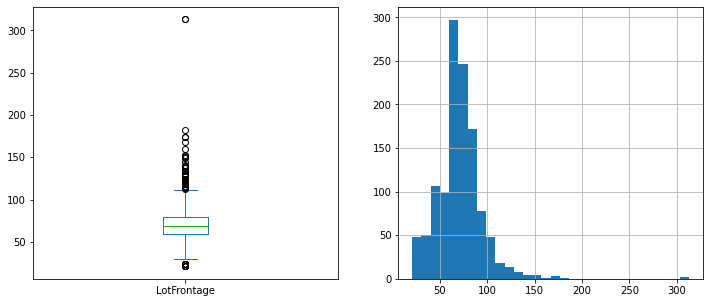

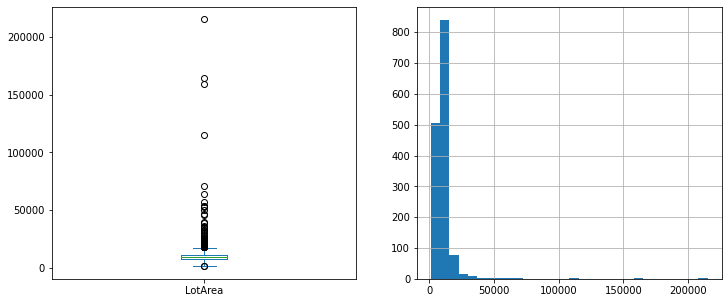

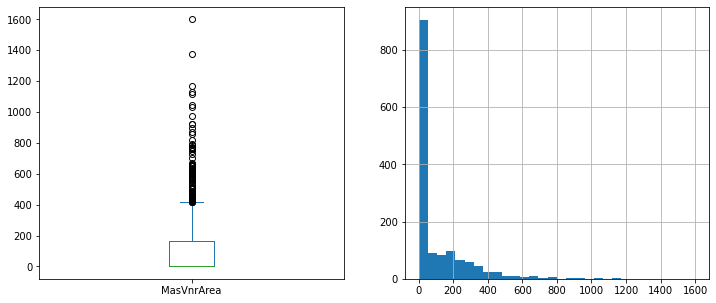

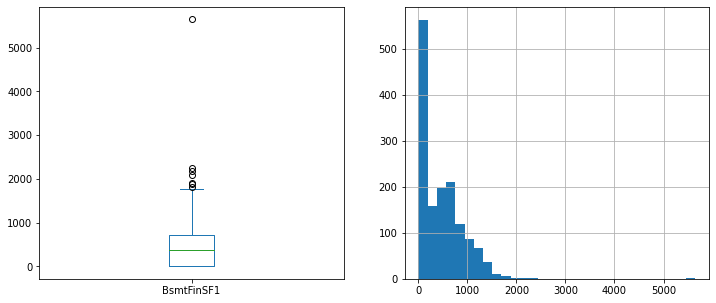

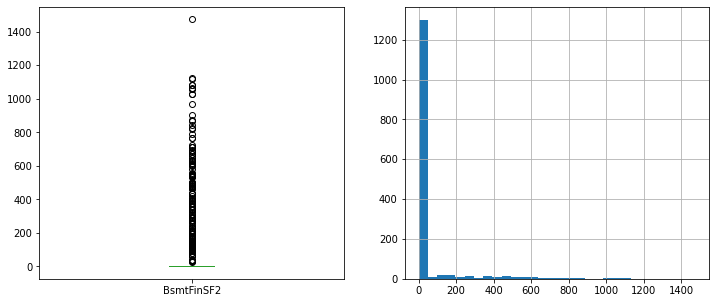

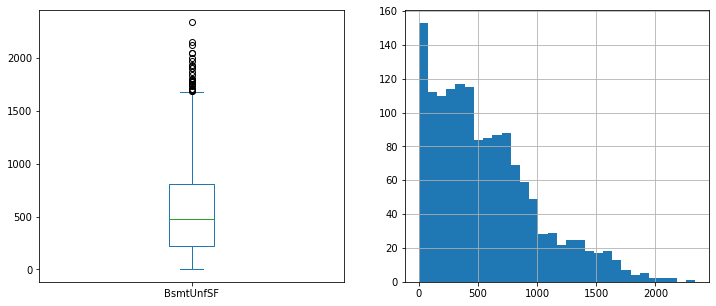

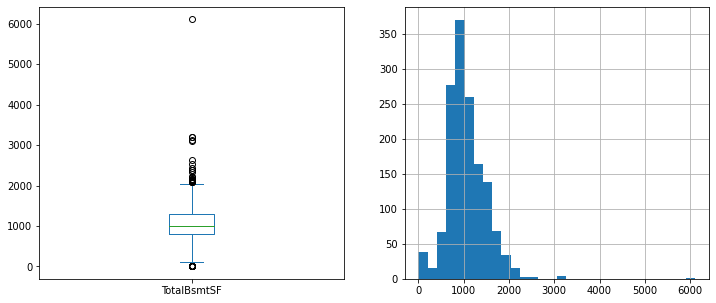

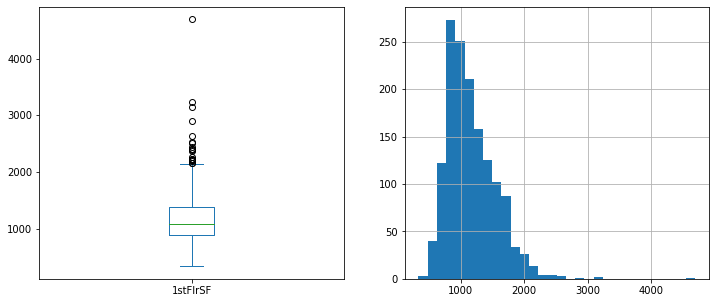

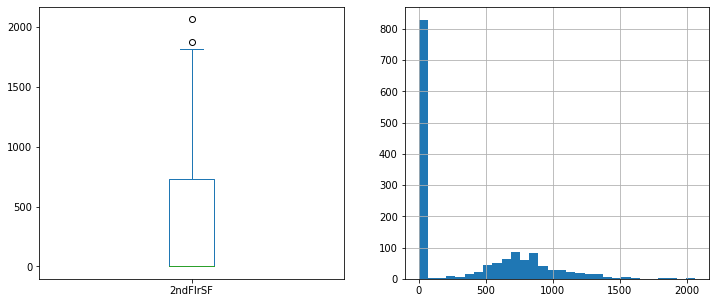

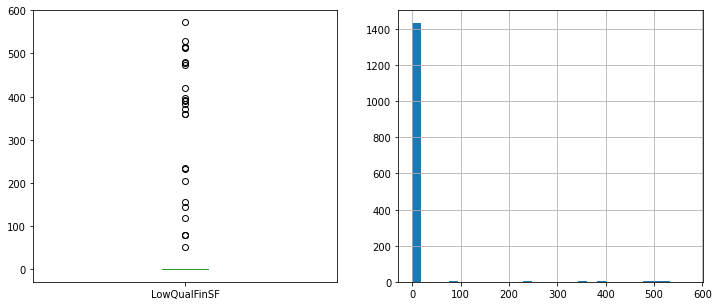

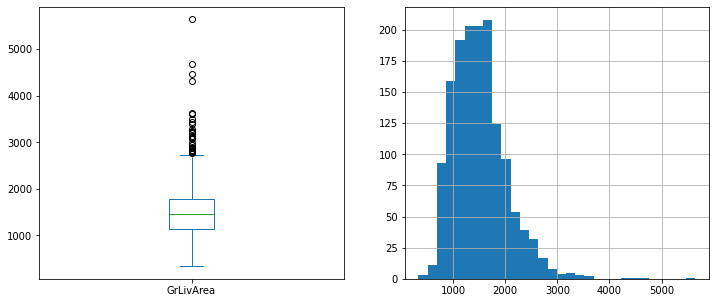

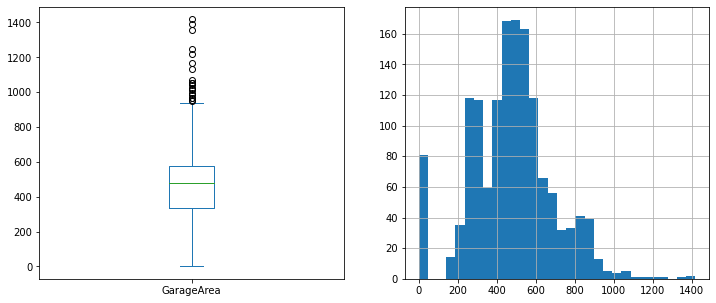

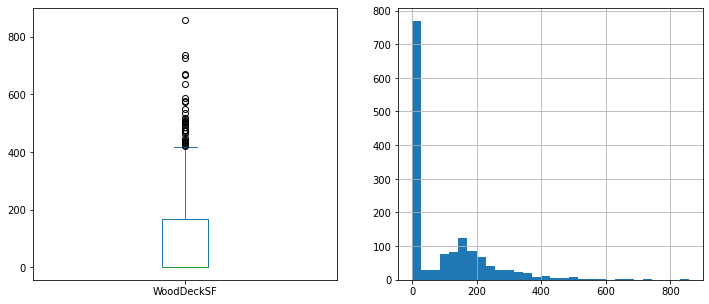

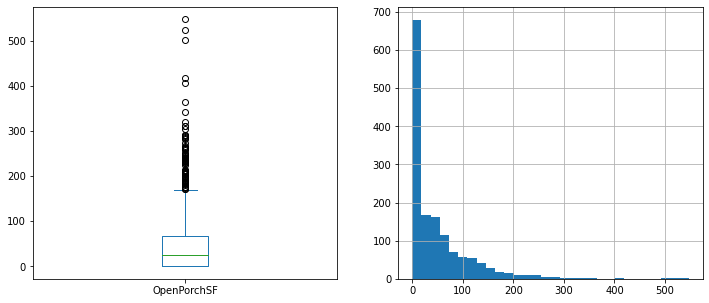

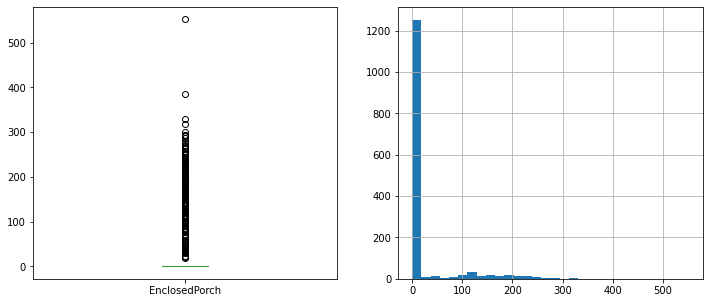

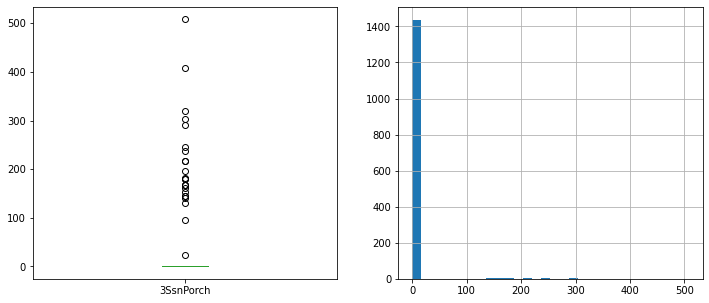

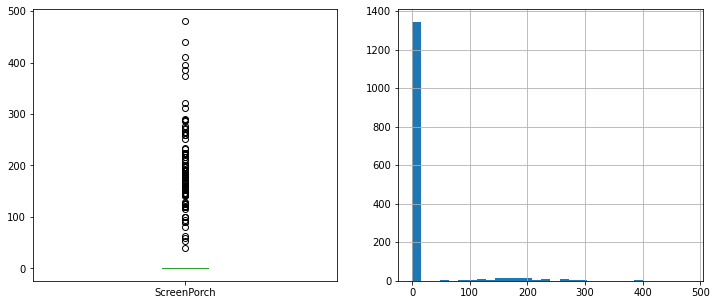

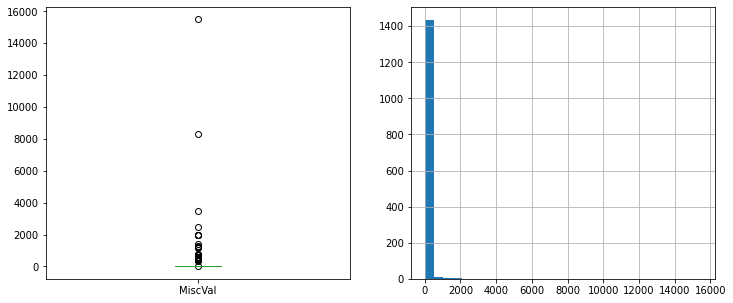

In [38]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    data[var].plot.box()
    
    plt.subplot(1,2,2)
    data[var].hist(bins=30)

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. To tackle the 2 aspects together, I will do discretisation. I will follow discretisation with encoding of the intervals following the target mean.

#### Outliers in discrete variables

Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % of the houses. This is exactly the same as finding rare labels in categorical variables. **Discrete variables can be pre-processed / engineered as if they were categorical**. 

In [44]:
#'MSSubClass'
(data['MSSubClass'].value_counts()/len(data)).sort_values()

40     0.002740
180    0.006849
45     0.008219
75     0.010959
85     0.013699
190    0.020548
90     0.035616
80     0.039726
70     0.041096
160    0.043151
30     0.047260
120    0.059589
50     0.098630
60     0.204795
20     0.367123
Name: MSSubClass, dtype: float64

In [45]:
(data.groupby('MSSubClass')['MSSubClass'].count()/len(data)).sort_values()

MSSubClass
40     0.002740
180    0.006849
45     0.008219
75     0.010959
85     0.013699
190    0.020548
90     0.035616
80     0.039726
70     0.041096
160    0.043151
30     0.047260
120    0.059589
50     0.098630
60     0.204795
20     0.367123
Name: MSSubClass, dtype: float64

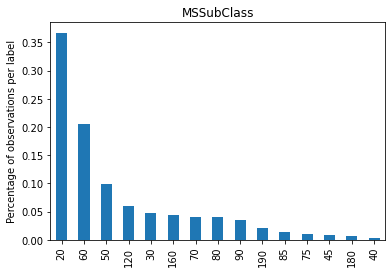

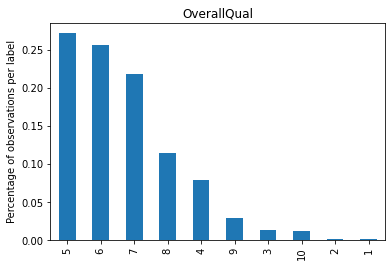

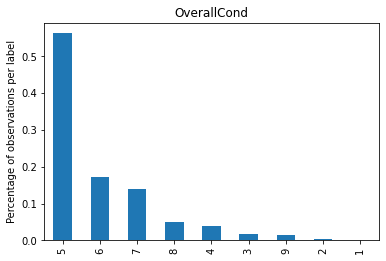

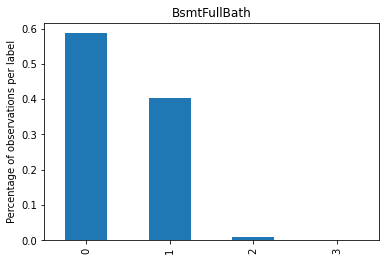

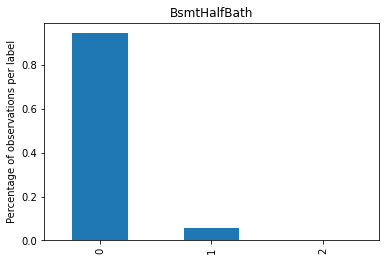

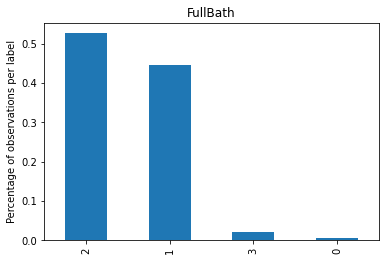

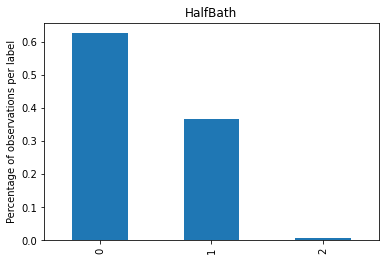

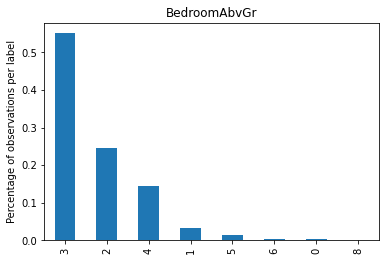

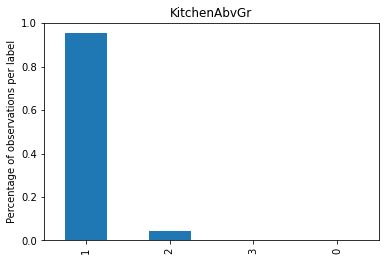

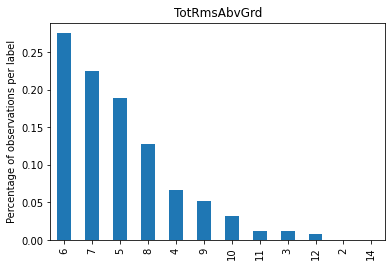

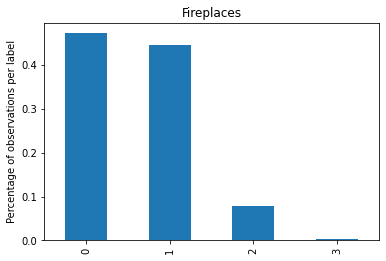

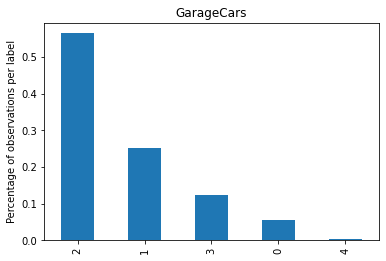

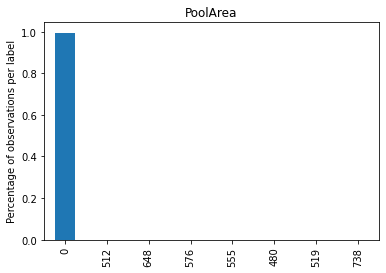

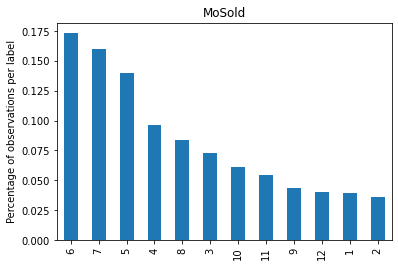

In [50]:
for var in discrete:
    (data[var].value_counts()/len(data)).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show();

Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset.

### Monotonicity between discrete variables and target values

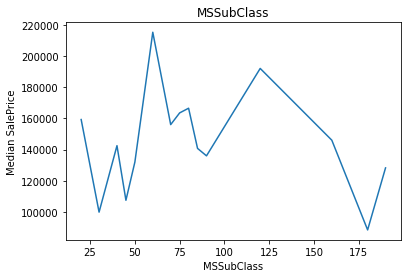

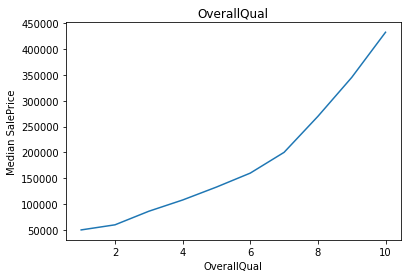

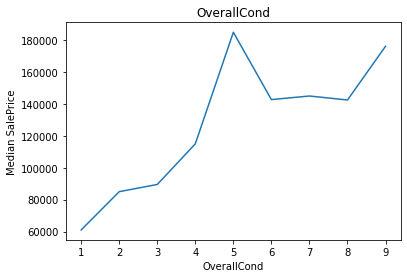

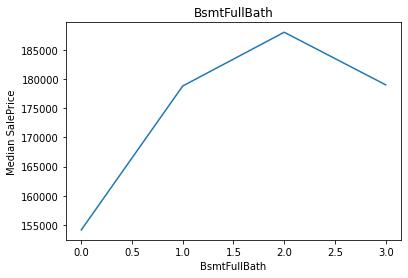

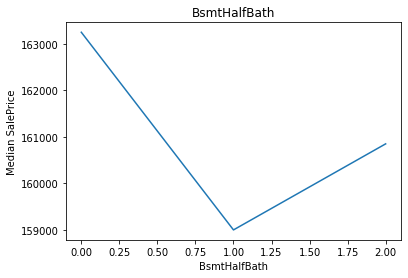

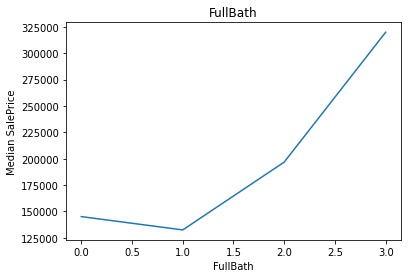

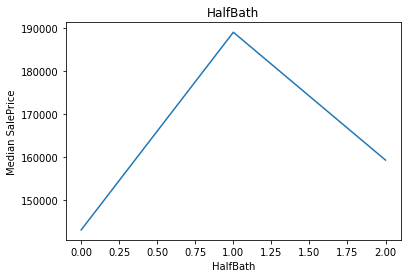

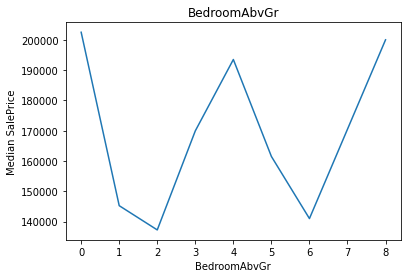

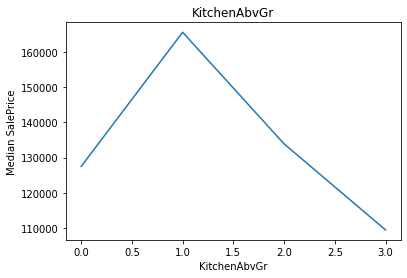

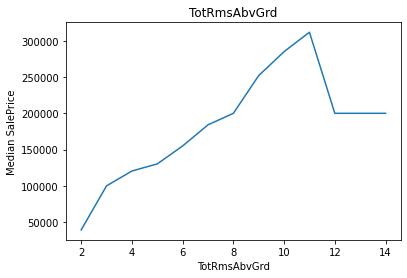

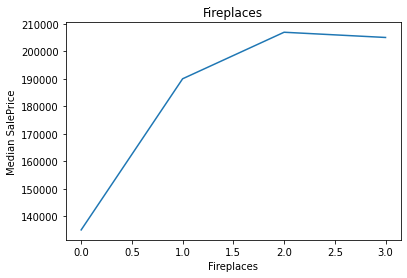

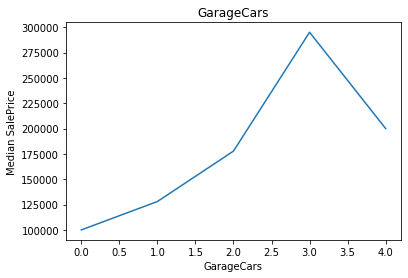

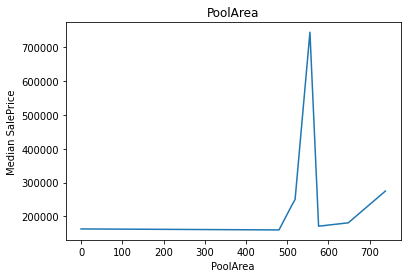

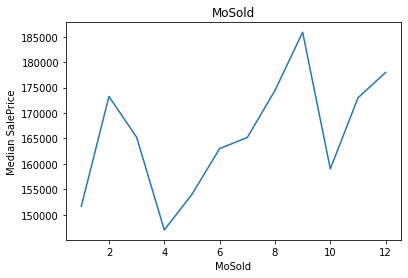

In [58]:
for var in discrete:
    data.groupby(var)['SalePrice'].median().plot()
    plt.ylabel('Median SalePrice')
    plt.title(var)
    plt.show();

Some of the discrete variables show some sort of monotonic relationship and some don't.

#### Number of labels: cardinality

Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

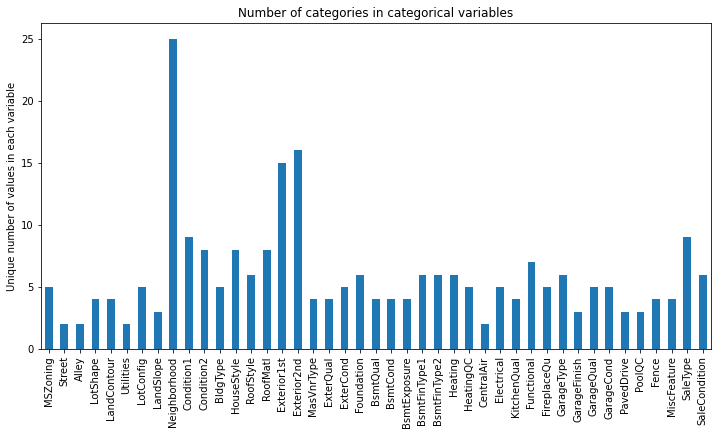

In [66]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(12, 6))
plt.title('Number of categories in categorical variables')
plt.ylabel('Unique number of values in each variable')
plt.show();

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Very likely though, they contain rare labels. Lets check the frequency of each categorical variables

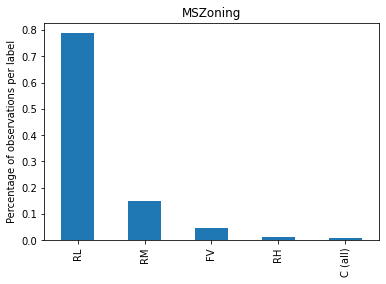

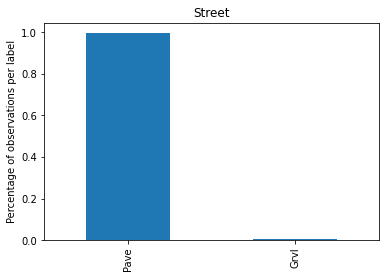

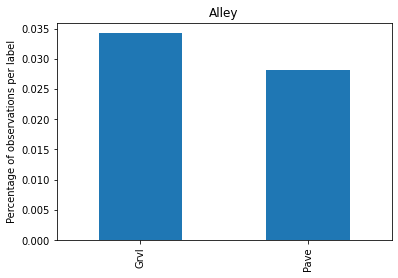

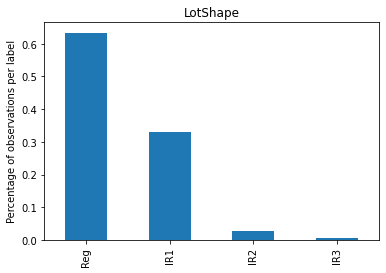

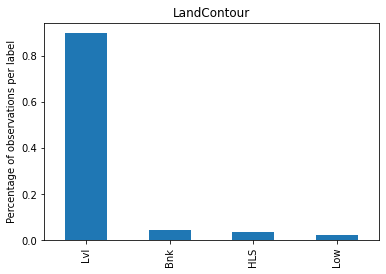

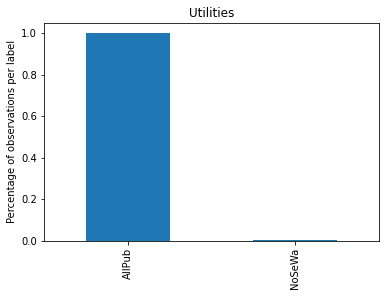

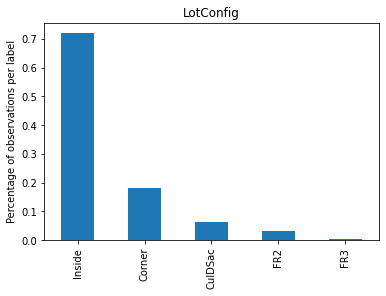

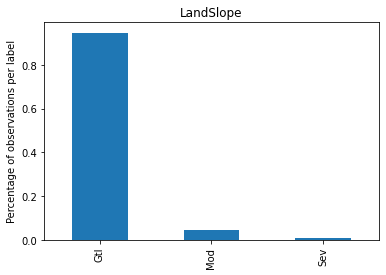

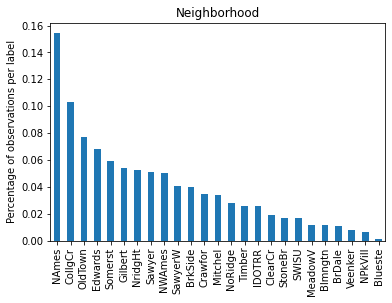

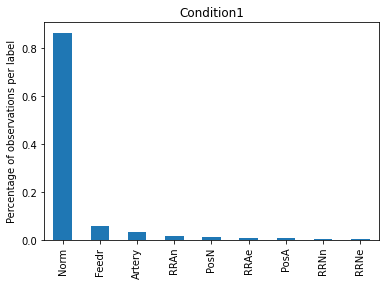

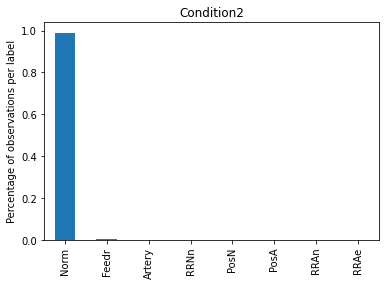

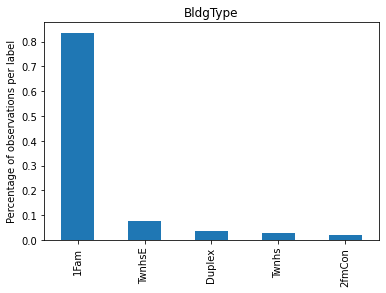

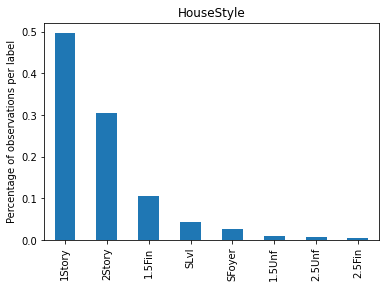

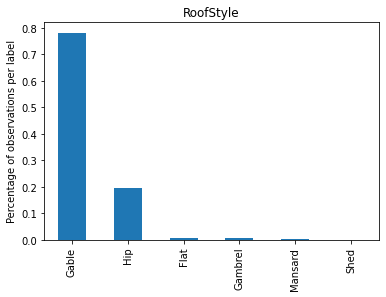

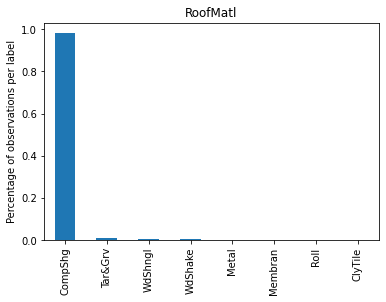

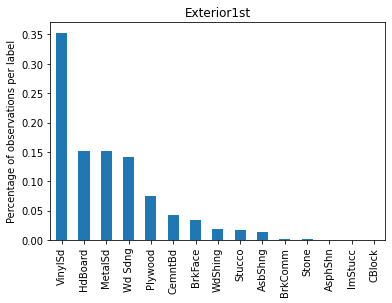

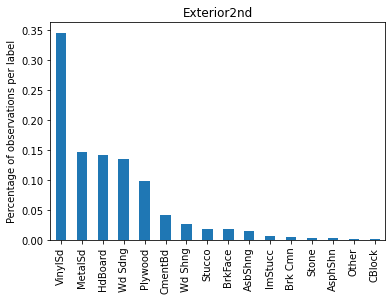

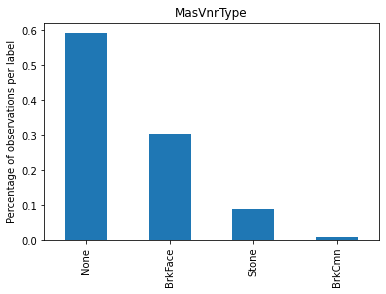

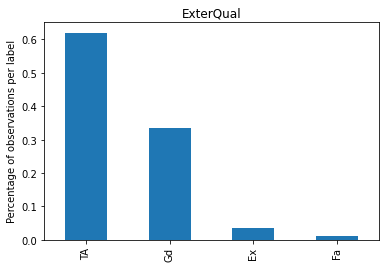

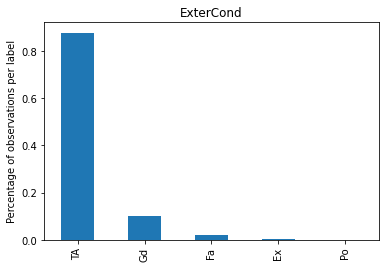

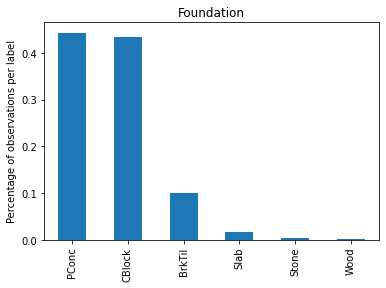

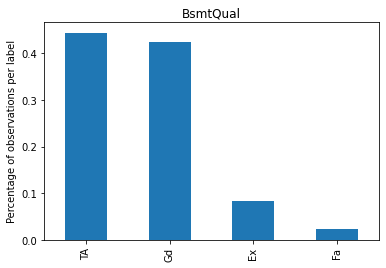

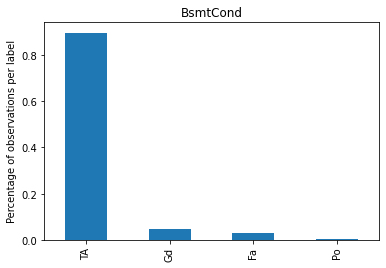

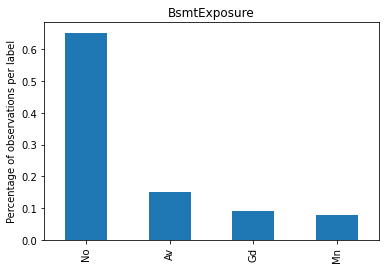

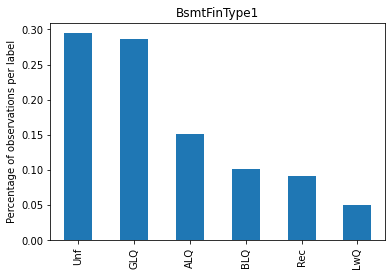

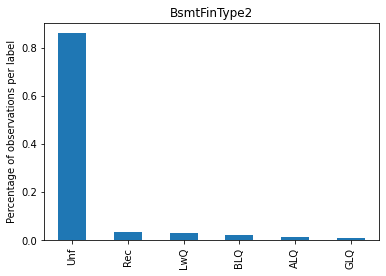

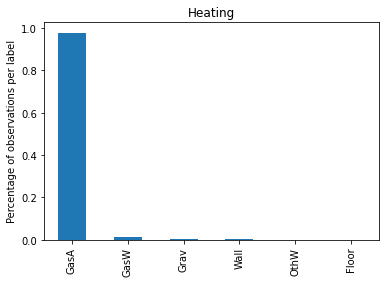

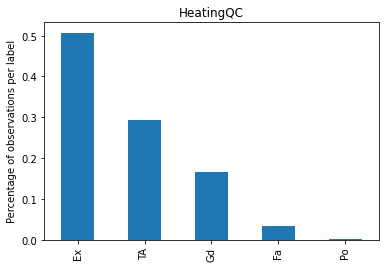

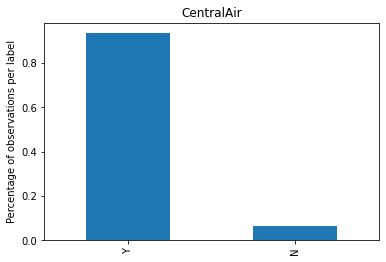

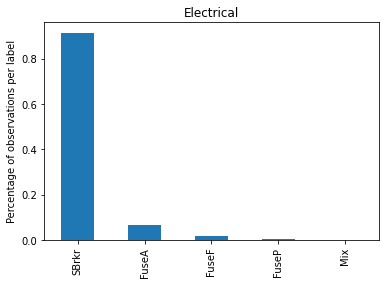

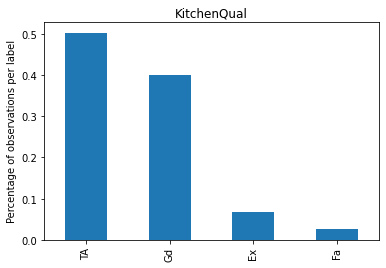

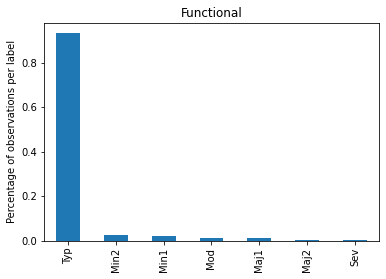

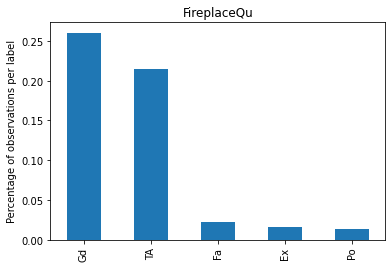

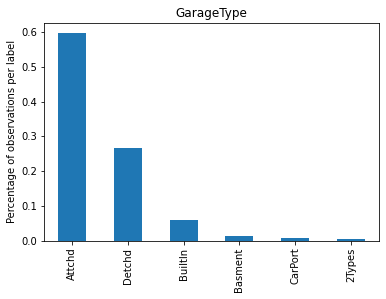

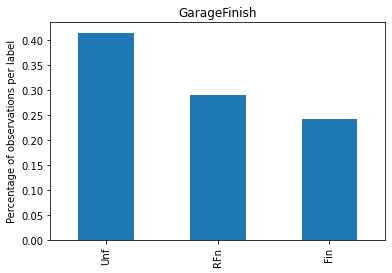

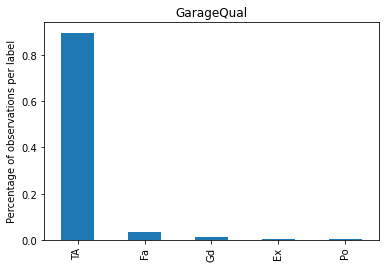

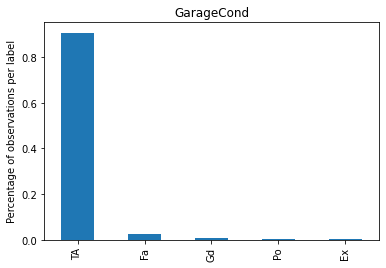

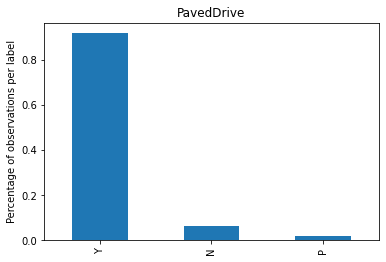

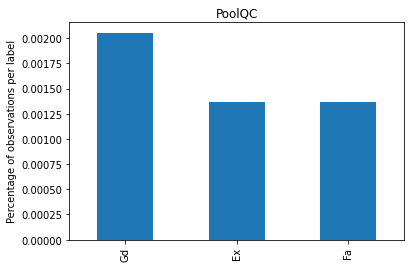

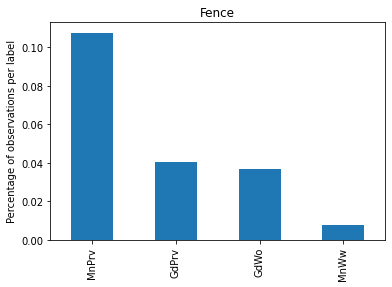

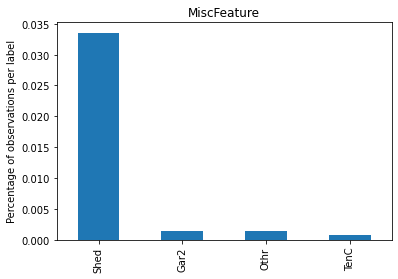

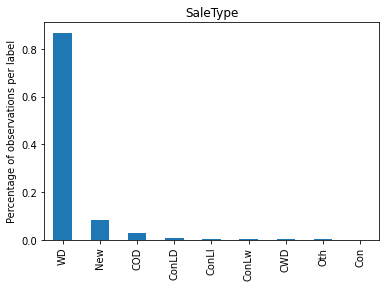

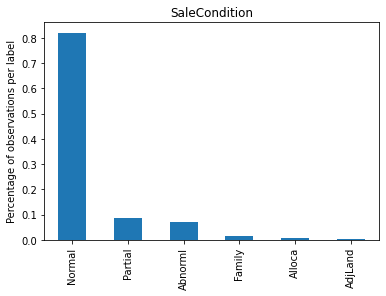

In [67]:
for var in categorical:
    (data[var].value_counts()/len(data)).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show();

### Separate train and test set

In [68]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset.**

### Temporal variables

First, we will create those temporal variables we discussed a few cells ago

In [69]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [70]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [71]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


Instead of the "year", now we have the amount of **years that passed** since the house was built or remodeled and the house was sold. Next, we drop the YrSold variable from the datasets, because we already extracted its value.

In [72]:
X_train.drop(['YrSold'], axis = 1, inplace = True)
X_test.drop(['YrSold'], axis = 1, inplace = True)

In [73]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

### Missing data imputation
#### Continuous variables

In [74]:
# print variables with missing data
# keep in mind that now that we created those new temporal variables, we
# are going to treat them as numerical and continuous:

# remove YrSold from the variable list
# because it is no longer in our dataset
year_vars.remove('YrSold')

for var in numerical+year_vars:
    if X_train[var].isnull().sum()>0:
        print(var, X_train[var].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


Imputation technique to use: **additional variable with NA + median imputation**

In [75]:
# print variables with missing data

for var in categorical:
    if X_train[var].isnull().sum()>0:
        print(var, X_train[var].isnull().mean())

Alley 0.9383561643835616
MasVnrType 0.0045662100456621
BsmtQual 0.0243531202435312
BsmtCond 0.0243531202435312
BsmtExposure 0.02511415525114155
BsmtFinType1 0.0243531202435312
BsmtFinType2 0.02511415525114155
Electrical 0.00076103500761035
FireplaceQu 0.4726027397260274
GarageType 0.0563165905631659
GarageFinish 0.0563165905631659
GarageQual 0.0563165905631659
GarageCond 0.0563165905631659
PoolQC 0.9954337899543378
Fence 0.8143074581430746
MiscFeature 0.9611872146118722


Imputation technique to use: **Add missing label to categorical variables**

## Putting it all together

In [76]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [77]:
# create pipeline

house_pipe = Pipeline([
    
    # numerical imputation
    # first add missing indicator
    ('missing_ind', mdi.AddMissingIndicator(variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    # impute with median value
    ('impute_num', mdi.MeanMedianImputer(imputation_method='median',
                                        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    # categorical imputation
    ('impute_cat', mdi.CategoricalImputer(variables=categorical)),
    
    # categorical encoding 
    # + discrete as we are treating discrete as categorical 
    ('rare_label_encode', ce.RareLabelEncoder(tol=0.05, n_categories=6, variables=categorical+discrete)),
    
    ('categorical_encoder', ce.OrdinalEncoder(variables=categorical+discrete)),
    
    # discretization
    ('discretize', dsc.EqualFrequencyDiscretiser(q=5, return_object=True, variables=numerical)),
    
    # encode the discretize numerical variables which are now object types
    ('cat_encode', ce.OrdinalEncoder(variables=numerical)),
    
    # scaling
    ('scaler', StandardScaler()),
    
    # Lasso
    ('lasso', Lasso(random_state=0))
    
])

In [78]:
# fit the pipeline with the training data
house_pipe.fit(X_train, y_train)

C:\Users\budha\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\budha\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\budha\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\budha\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning

Pipeline(steps=[('missing_ind',
                 AddMissingIndicator(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('impute_num',
                 MeanMedianImputer(variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('impute_cat',
                 CategoricalImputer(variables=['MSZoning', 'Street', 'Alley',
                                               'LotShape', 'LandContour',
                                               'Utilities', 'LotConfig',
                                               'LandSlope', 'Neighborhood',
                                               'Conditio...
                                                      'ScreenPorch',
                                                      'MiscVal'])),
                ('cat_encode',
                 OrdinalEncoder(variables=['LotFrontage', 'LotArea',
                          

In [79]:
# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

In [80]:
# a peek into the prediction values
X_train_preds

array([246672.4052138 , 161896.12892056, 293729.93370089, ...,
       101967.70191474, 210530.36056505, 234850.78615547])

In [83]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 1035269885.2749027
train rmse: 32175.610099497768
train r2: 0.834193183650799

test mse: 2006905385.1371982
test rmse: 44798.49757678485
test r2: 0.7079639526659388


Text(0, 0.5, 'Predicted Price')

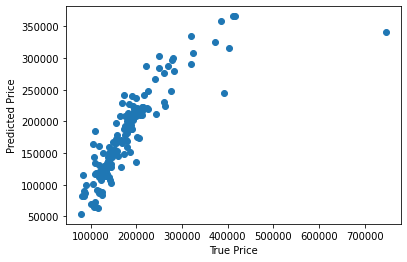

In [84]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

In [87]:
# explore the lasso properties
house_pipe.named_steps

{'missing_ind': AddMissingIndicator(variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt']),
 'impute_num': MeanMedianImputer(variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt']),
 'impute_cat': CategoricalImputer(variables=['MSZoning', 'Street', 'Alley', 'LotShape',
                               'LandContour', 'Utilities', 'LotConfig',
                               'LandSlope', 'Neighborhood', 'Condition1',
                               'Condition2', 'BldgType', 'HouseStyle',
                               'RoofStyle', 'RoofMatl', 'Exterior1st',
                               'Exterior2nd', 'MasVnrType', 'ExterQual',
                               'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
                               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                               'Heating', 'HeatingQC', 'CentralAir',
                               'Electrical', ...]),
 'rare_label_encode': RareLabelEncoder(n_categories=6,
                  variables=['M

In [90]:
house_pipe.named_steps['lasso'].coef_

array([ 1861.01502063,  2754.45143383,   205.05327485,  5231.80372979,
        2068.19798341,  1218.63397865,  2417.77114375,  1347.87398691,
         997.64806749,  2808.48979976,   413.12088403,  5108.94132199,
        3120.84865026,  2163.08822989,   416.25708668,  -571.90221927,
        8456.16142586,   109.9758049 , 10634.34090162, -1325.95526039,
        4532.79271389,  1421.45129491,  6665.93038319, -7397.85573077,
         912.67181783,   993.87457038,  9790.63358394,  -143.00576462,
         840.60581476,  6533.87509374, -1046.32657066,  5344.93846318,
        1465.55786566,  3415.11727263, -1870.91418323,     0.        ,
         635.09725291,  4713.8048117 ,  -218.68201605,   353.08807716,
        3633.38988833,  -685.47100279,  6251.42290131,  1113.26923149,
           0.        ,  9864.99936045,  3553.33178698, -1152.59390721,
        4498.33812919,  6760.59868333, -1843.65804913,  3506.11118029,
        7449.53178237,  6601.21489776,  4772.76441594,  2988.13490705,
      

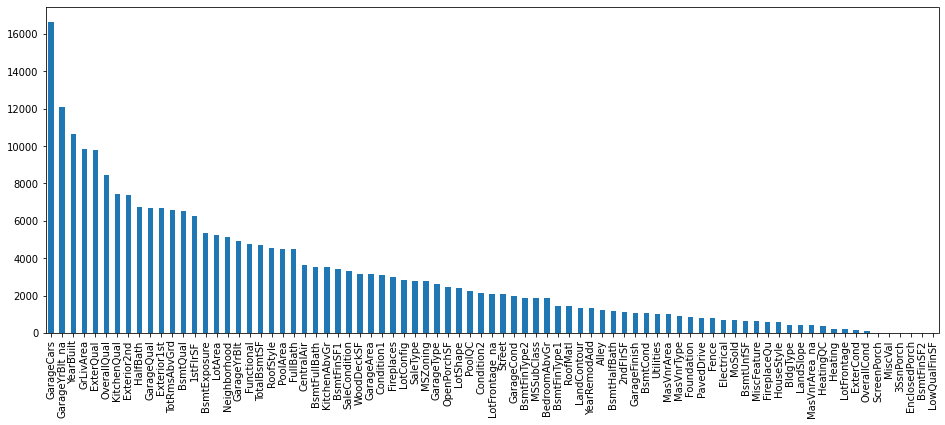

In [94]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns) + ['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(ascending=False).plot.bar(figsize=(16,6))
plt.show();